In [1]:
import pandas as pd
import re, math, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colorbar, matplotlib.colors, matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
pickle_= open('tv100_Data_dict.pickle','rb')
top100_dict= pickle.load(pickle_)
pickle_2= open('tv100_AvgRating_dict.pickle', 'rb')
Avg_rating_dict= pickle.load(pickle_2)

In [3]:
def transform_to_df(data_dict):
    
    master_df= pd.DataFrame(columns=["TVSeries","airdate", "duration", "episode", "genre", "rating", "title", "usersCount"])
    for seriesi in data_dict:
        series_df= pd.DataFrame.from_dict(data_dict[seriesi], orient="columns")
        series_df["TVSeries"]= seriesi
        master_df= pd.concat([master_df, series_df])
    
    return master_df

In [4]:
top100= transform_to_df(top100_dict)
top100.reset_index(drop=True, inplace=True)

In [5]:
top100[["Season", "Episode"]] = top100.episode.str.extract(r'(.+)\s?\|\s?(.+)', expand=True)
top100.drop("episode", inplace=True, axis=1)
top100.usersCount= top100.usersCount.str.replace(",", "").astype('int32')
top100.airdate= pd.to_datetime(top100.airdate)
top100.rating= top100.rating.astype('float32')

In [6]:
top100["Avg_Rating"]= top100.loc[:,"TVSeries"]
top100["Avg_Rating"]= top100["Avg_Rating"].map(Avg_rating_dict)

In [7]:
def take_time(x):
    if len(x)>0:
        return np.float(x[0])
    else:
        return 0
top100["duration_min"]= top100["duration"].str.findall(r'(\d+)h').apply(lambda x: take_time(x))*60 + \
top100["duration"].str.findall(r'(\d+)min').apply(lambda x: take_time(x))

In [8]:
print(top100.shape)
top100.head(10)

(6069, 11)


,TVSeries,airdate,duration,genre,rating,title,usersCount,Season,Episode,Avg_Rating,duration_min
0,Planet Earth II,2016-11-06,1h,[Documentary],8.6,Islands,2447,Season 1,Episode 1,9.6,60.0
1,Planet Earth II,2016-11-13,6h,[Documentary],7.9,Mountains,1712,Season 1,Episode 2,9.6,360.0
2,Planet Earth II,2016-11-20,6h,[Documentary],7.5,Jungles,1445,Season 1,Episode 3,9.6,360.0
3,Planet Earth II,2016-11-27,49min,[Documentary],7.5,Deserts,1216,Season 1,Episode 4,9.6,49.0
4,Planet Earth II,2016-12-04,49min,[Documentary],7.4,Grasslands,1036,Season 1,Episode 5,9.6,49.0
5,Planet Earth II,2016-12-11,49min,[Documentary],7.4,Cities,1102,Season 1,Episode 6,9.6,49.0
6,Band of Brothers,2001-09-09,1h 10min,"[Action, Drama, History]",8.6,Currahee,4150,Season 1,Episode 1,9.5,70.0
7,Band of Brothers,2001-09-09,49min,"[Action, Drama, History]",8.9,Day of Days,3820,Season 1,Episode 2,9.5,49.0
8,Band of Brothers,2001-09-16,1h 2min,"[Action, Drama, History]",8.7,Carentan,3433,Season 1,Episode 3,9.5,62.0
9,Band of Brothers,2001-09-23,57min,"[Action, Drama, History]",8.6,Replacements,3219,Season 1,Episode 4,9.5,57.0


In [9]:
top100.dropna(subset=[["Season", "Episode"]],axis=0, inplace=True)
top100["Episode"]= top100.Episode.str.findall('\d+').apply(lambda x: x[0]).astype('int32')
top100["Season"]= top100.Season.str.findall('\d+').apply(lambda x: x[0]).astype('int32')

In [10]:
top100["log_usersCount"]=  np.log(top100.usersCount)

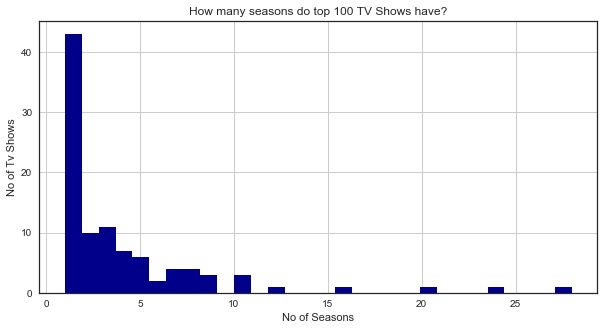

In [11]:
sns.set_style('white')
plt.figure(figsize=(10,5))
top100.loc[:, ["TVSeries", "Season"]].drop_duplicates(subset= ["TVSeries", "Season"])["TVSeries"].value_counts().hist(bins=30, color='darkblue')
plt.xlabel('No of Seasons')
plt.ylabel('No of Tv Shows')
plt.title('How many seasons do top 100 TV Shows have?')
plt.show()

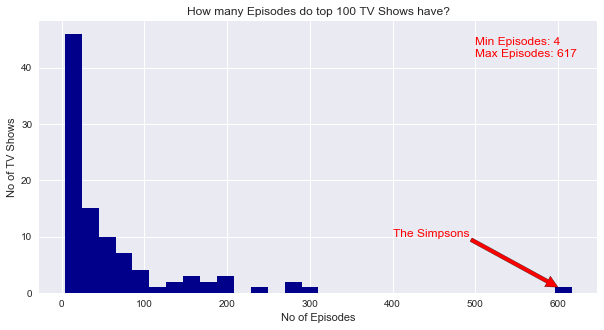

In [12]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
episodelist= top100.TVSeries.value_counts()
episodelist.hist(bins=30, color= 'darkblue')
plt.xlabel('No of Episodes')
plt.ylabel('No of TV Shows')
plt.title('How many Episodes do top 100 TV Shows have?')
plt.text(500,42,"Min Episodes: "+str(episodelist.min())+"\n"+ "Max Episodes: "+ str(episodelist.max()), color='red')
plt.annotate(episodelist.idxmax(), xy= (600,1), xytext=(400,10), arrowprops= {'facecolor': 'red'}, color="red")
plt.show()

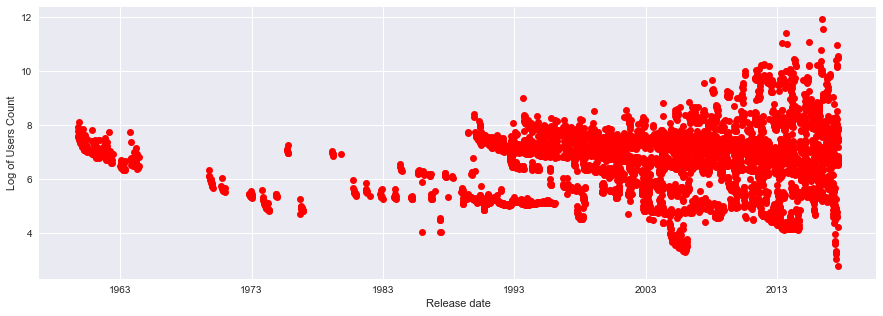

In [13]:
plt.figure(figsize=(15,5))
plt.plot(top100.airdate, top100.log_usersCount, "ro")
sns.set_style('white')
plt.ylabel('Log of Users Count')
plt.xlabel('Release date')
plt.show()

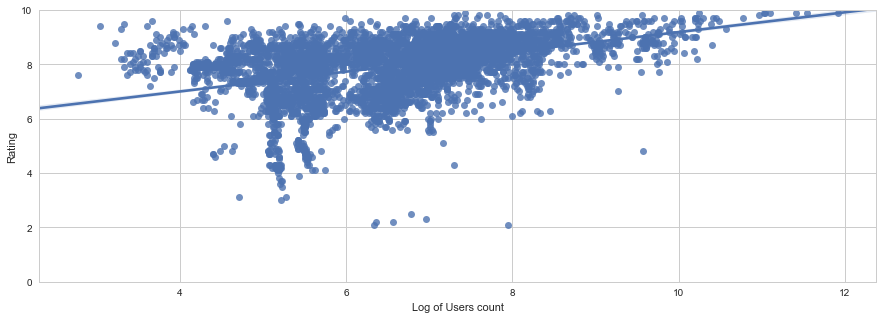

In [14]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')
sns.regplot("log_usersCount", "rating", data=top100)
plt.ylim((0,10))
plt.xlabel('Log of Users count')
plt.ylabel('Rating')
plt.show()

In [15]:
userC= np.sort(top100.loc[:,'usersCount'])
norm = matplotlib.colors.Normalize(vmin= userC[math.ceil(len(userC)*0.01)], 
                                   vmax= userC[math.ceil(len(userC)*0.99)]) # not including far off values

def plot_tvshows(tvshow, ylim= (6,10)):
    cmap= matplotlib.cm.YlGnBu

    colors = {}
    for cval in userC:
        colors.update({cval : cmap(norm(cval))})

    fig, ax1 = plt.subplots(1,1 , figsize=(15,5))

    sns.swarmplot(x= 'Season',y= 'rating',data=top100.loc[top100.TVSeries==tvshow,:], palette=colors, size=7,
                  hue='usersCount', order= np.sort(top100.loc[top100.TVSeries==tvshow,'Season'].unique()), ax=ax1)
    sns.pointplot(x= 'Season',y= 'rating',data=top100.loc[top100.TVSeries==tvshow,:],color="turquoise",linestyles='--',
                  markers='x', order= np.sort(top100.loc[top100.TVSeries==tvshow,'Season'].unique()), ax=ax1, ci=95, 
                  errwidth=2)
    
    sns.set(rc={'axes.facecolor':'grey', 'figure.facecolor':'white'})
    ax1.legend_.remove()
    ax1.set_ylabel('Rating')
    ax1.set_ylim(ylim)
    ax1.set_title('Rating and Popularity across seasons: '+tvshow, fontdict={'fontsize':15})
    
    divider = make_axes_locatable(plt.gca())
    cb = divider.new_horizontal(size="2%", pad=0.05)
    fig.add_axes(cb)
    col_bar= matplotlib.colorbar.ColorbarBase(cb, cmap=cmap, norm=norm, orientation='vertical')
    col_bar.set_label('Users Count')
    plt.rc_context({'xtick.color':'black', 'ytick.color':'black', 'axes.labelcolor': 'black', 'axes.labelsize':15, 
                    'ytick.labelsize':15, 'xtick.labelsize':15})

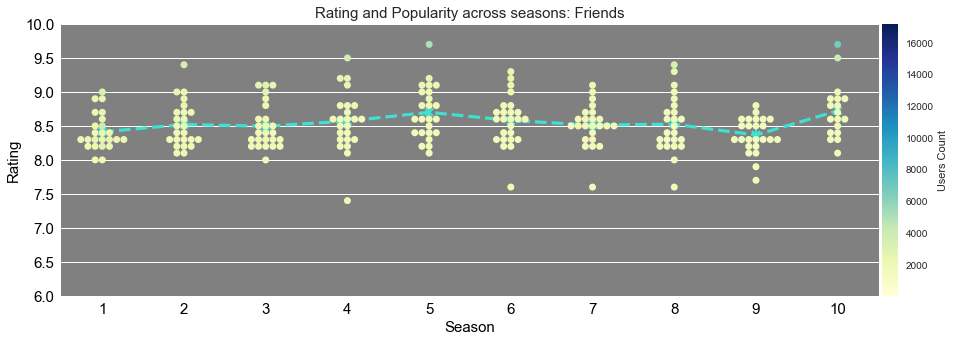

In [17]:
plot_tvshows('Friends')

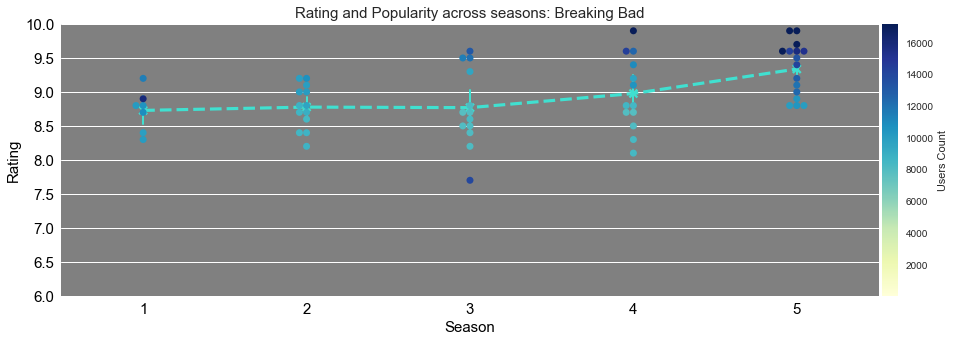

In [18]:
plot_tvshows('Breaking Bad')

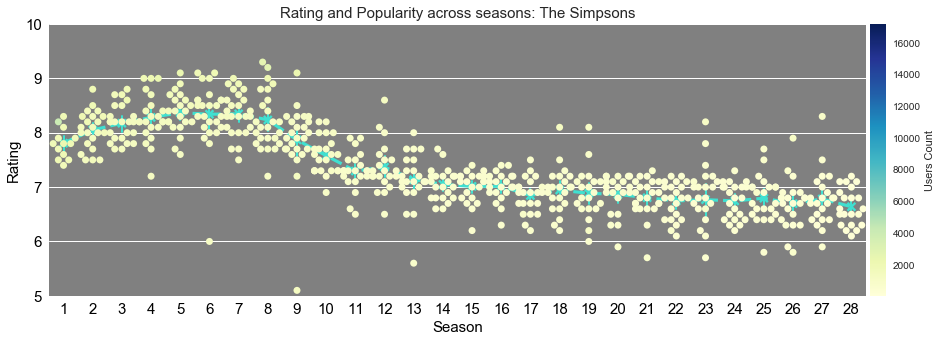

In [19]:
plot_tvshows('The Simpsons', (5,10))